In [ ]:
#https://github.com/anuraggupta29/vehicle-speed-detection/tree/master

In [ ]:
#Detect speed of vehicles on multi-lane highways.

In [6]:
import cv2
import dlib
import time
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

#CLASSIFIER FOR DETECTING CARS--------------------------------------------------
carCascade = cv2.CascadeClassifier('HaarCascadeClassifier.xml')
#detects the vehicles

#TAKE VIDEO---------------------------------------------------------------------
video = cv2.VideoCapture('videoTest.mp4')

WIDTH = 1280 #WIDTH OF VIDEO FRAME
HEIGHT = 720 #HEIGHT OF VIDEO FRAME
cropBegin = 240 #CROP VIDEO FRAME FROM THIS POINT
mark1 = 120 #MARK TO START TIMER
mark2 = 360 #MARK TO END TIMER
markGap = 15 #DISTANCE IN METRES BETWEEN THE MARKERS
fpsFactor = 3 #TO COMPENSATE FOR SLOW PROCESSING
speedLimit = 20 #SPEEDLIMIT
startTracker = {} #STORE STARTING TIME OF CARS
endTracker = {} #STORE ENDING TIME OF CARS

#MAKE DIRCETORY TO STORE OVER-SPEEDING CAR IMAGES
if not os.path.exists('overspeeding/cars/'):
    os.makedirs('overspeeding/cars/')

print('Speed Limit Set at 20 Kmph')


def blackout(image):
    xBlack = 360
    yBlack = 300
    triangle_cnt = np.array( [[0,0], [xBlack,0], [0,yBlack]] )
    triangle_cnt2 = np.array( [[WIDTH,0], [WIDTH-xBlack,0], [WIDTH,yBlack]] )
    cv2.drawContours(image, [triangle_cnt], 0, (0,0,0), -1)
    cv2.drawContours(image, [triangle_cnt2], 0, (0,0,0), -1)

    return image

#FUCTION TO SAVE CAR IMAGE, DATE, TIME, SPEED ----------------------------------
def saveCar(speed,image):
    now = datetime.today().now()
    nameCurTime = now.strftime("%d-%m-%Y-%H-%M-%S-%f")

    link = 'overspeeding/cars/'+nameCurTime+'.jpeg'
    cv2.imwrite(link,image)

#FUNCTION TO CALCULATE SPEED----------------------------------------------------
def estimateSpeed(carID):
    timeDiff = endTracker[carID]-startTracker[carID]
    speed = round(markGap/timeDiff*fpsFactor*3.6,2)
    return speed

#FUNCTION TO TRACK CARS---------------------------------------------------------
def trackMultipleObjects():
    rectangleColor = (0, 255, 0)
    frameCounter = 0
    currentCarID = 0
    carTracker = {}

    while True:
        rc, image = video.read()
        if type(image) == type(None):
            break

        frameTime = time.time()
        image = cv2.resize(image, (WIDTH, HEIGHT))[cropBegin:720,0:1280]
        resultImage = blackout(image)
        cv2.line(resultImage,(0,mark1),(1280,mark1),(0,0,255),2)
        cv2.line(resultImage,(0,mark2),(1280,mark2),(0,0,255),2)

        frameCounter = frameCounter + 1

        #DELETE CARIDs NOT IN FRAME---------------------------------------------
        carIDtoDelete = []

        for carID in carTracker.keys():
            trackingQuality = carTracker[carID].update(image)

            if trackingQuality < 7:
                carIDtoDelete.append(carID)

        for carID in carIDtoDelete:
            carTracker.pop(carID, None)

        #MAIN PROGRAM-----------------------------------------------------------
        if (frameCounter%60 == 0):
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cars = carCascade.detectMultiScale(gray, 1.1, 13, 18, (24, 24)) #DETECT CARS IN FRAME

            for (_x, _y, _w, _h) in cars:
                #GET POSITION OF A CAR
                x = int(_x)
                y = int(_y)
                w = int(_w)
                h = int(_h)

                xbar = x + 0.5*w
                ybar = y + 0.5*h

                matchCarID = None

                #IF CENTROID OF CURRENT CAR NEAR THE CENTROID OF ANOTHER CAR IN PREVIOUS FRAME THEN THEY ARE THE SAME
                for carID in carTracker.keys():
                    trackedPosition = carTracker[carID].get_position()

                    tx = int(trackedPosition.left())
                    ty = int(trackedPosition.top())
                    tw = int(trackedPosition.width())
                    th = int(trackedPosition.height())

                    txbar = tx + 0.5 * tw
                    tybar = ty + 0.5 * th

                    if ((tx <= xbar <= (tx + tw)) and (ty <= ybar <= (ty + th)) and (x <= txbar <= (x + w)) and (y <= tybar <= (y + h))):
                        matchCarID = carID


                if matchCarID is None:
                    tracker = dlib.correlation_tracker()
                    tracker.start_track(image, dlib.rectangle(x, y, x + w, y + h))

                    carTracker[currentCarID] = tracker

                    currentCarID = currentCarID + 1


        for carID in carTracker.keys():
            trackedPosition = carTracker[carID].get_position()

            tx = int(trackedPosition.left())
            ty = int(trackedPosition.top())
            tw = int(trackedPosition.width())
            th = int(trackedPosition.height())

            #PUT BOUNDING BOXES-------------------------------------------------
            cv2.rectangle(resultImage, (tx, ty), (tx + tw, ty + th), rectangleColor, 2)
            cv2.putText(resultImage, str(carID), (tx,ty-5), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 1)

            #ESTIMATE SPEED-----------------------------------------------------
            if carID not in startTracker and mark2 > ty+th > mark1 and ty < mark1:
                startTracker[carID] = frameTime

            elif carID in startTracker and carID not in endTracker and mark2 < ty+th:
                endTracker[carID] = frameTime
                speed = estimateSpeed(carID)
                if speed > speedLimit:
                    print('CAR-ID : {} : {} kmph - OVERSPEED'.format(carID, speed))
                    saveCar(speed,image[ty:ty+th, tx:tx+tw])
                else:
                    print('CAR-ID : {} : {} kmph'.format(carID, speed))

        #DISPLAY EACH FRAME
        if frameCounter % 50 == 0:
          from google.colab.patches import cv2_imshow
          cv2_imshow(resultImage)
        #print(resultImage.shape)

        if cv2.waitKey(33) == 27:
            break

    cv2.destroyAllWindows()

if __name__ == '__main__':
    trackMultipleObjects()


Speed Limit Set at 20 Kmph


KeyboardInterrupt: ignored

Speed Limit Set at 20 Kmph


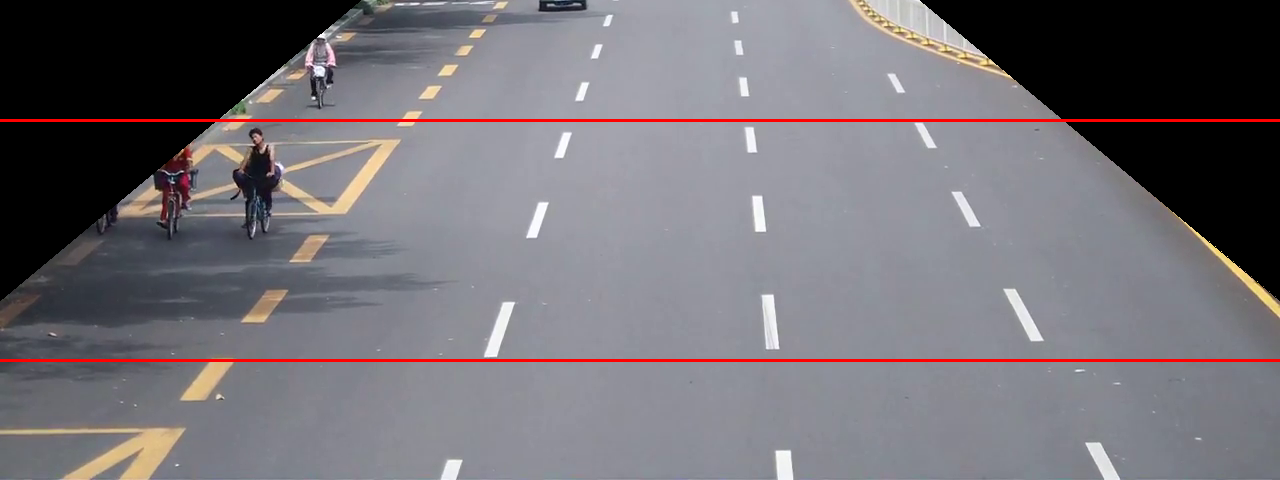

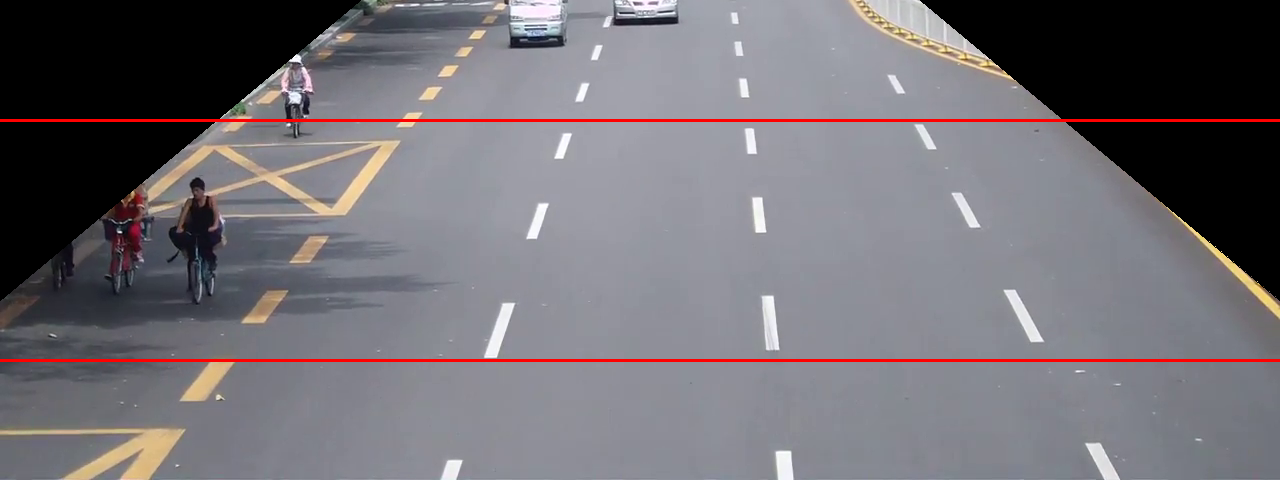

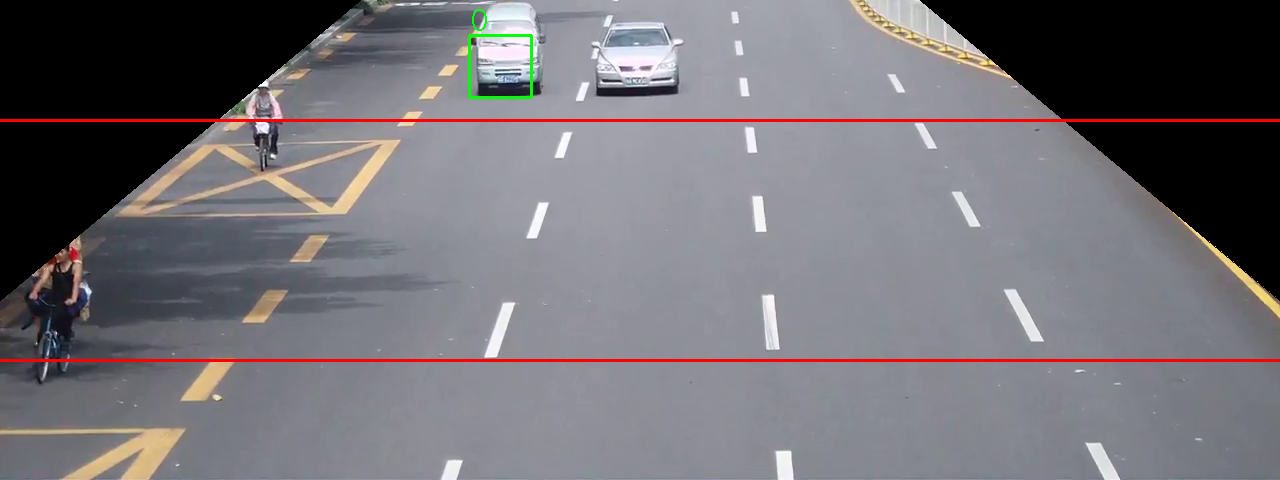

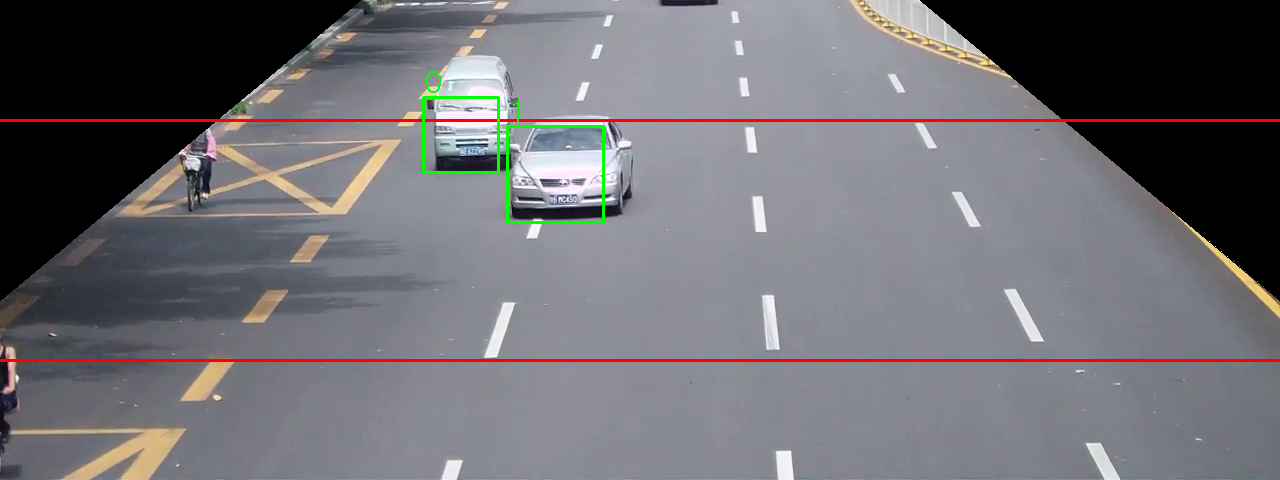

CAR-ID : 1 : 46.58 kmph - OVERSPEED


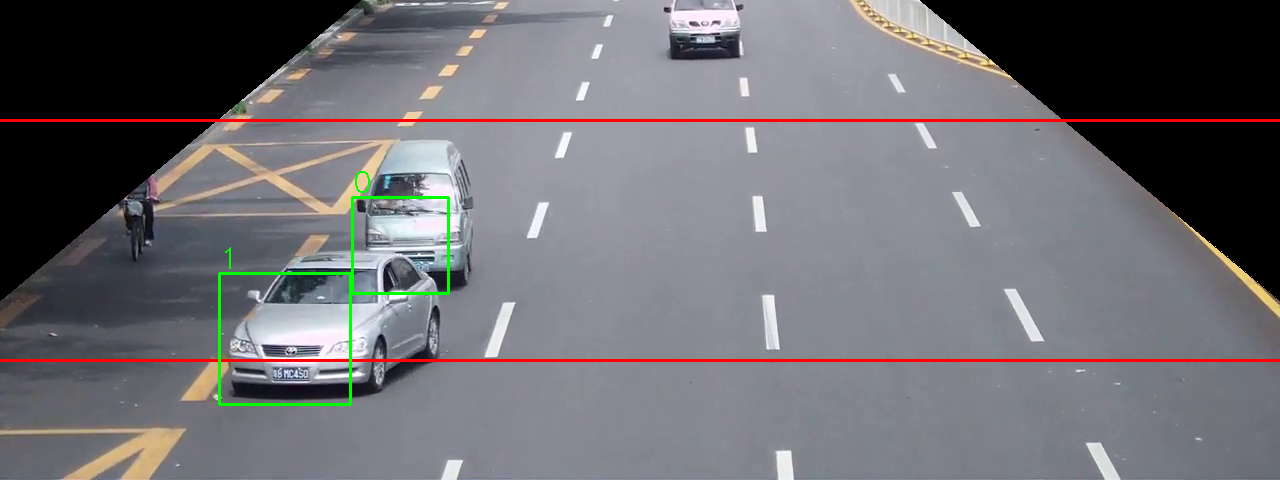

CAR-ID : 0 : 30.99 kmph - OVERSPEED


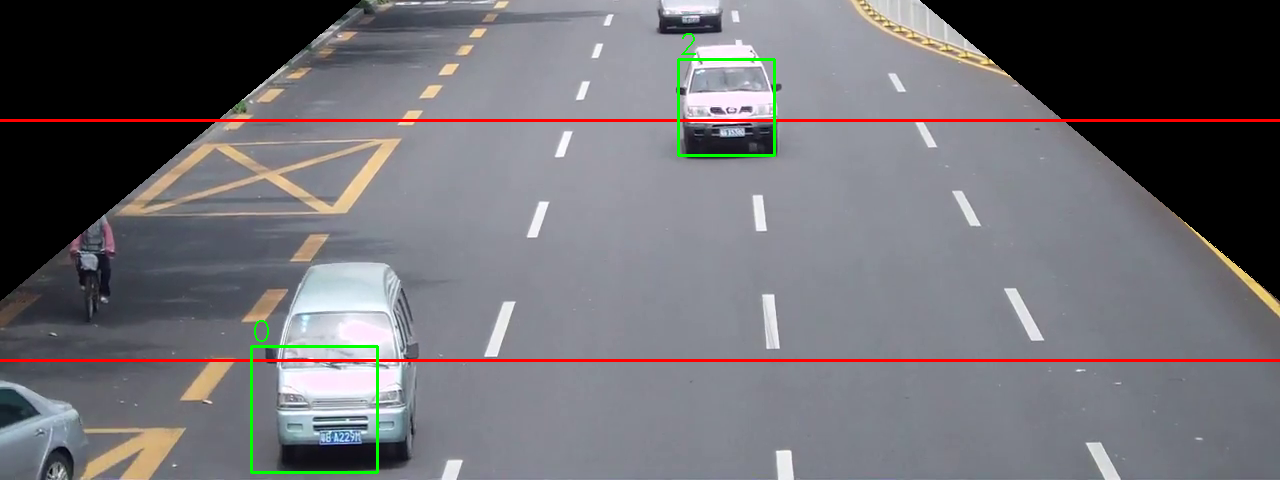

CAR-ID : 2 : 101.18 kmph - OVERSPEED


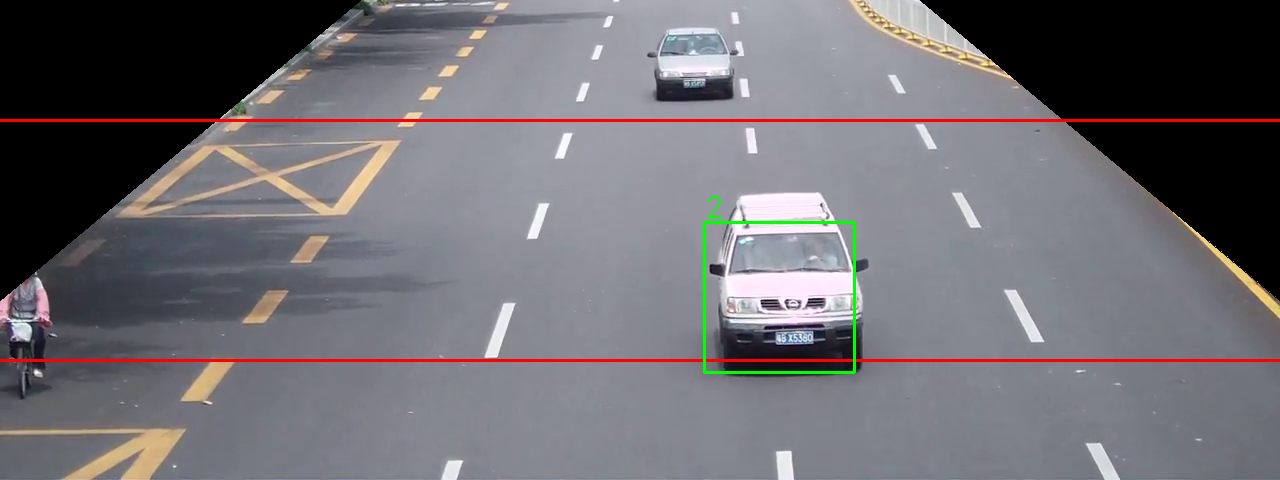

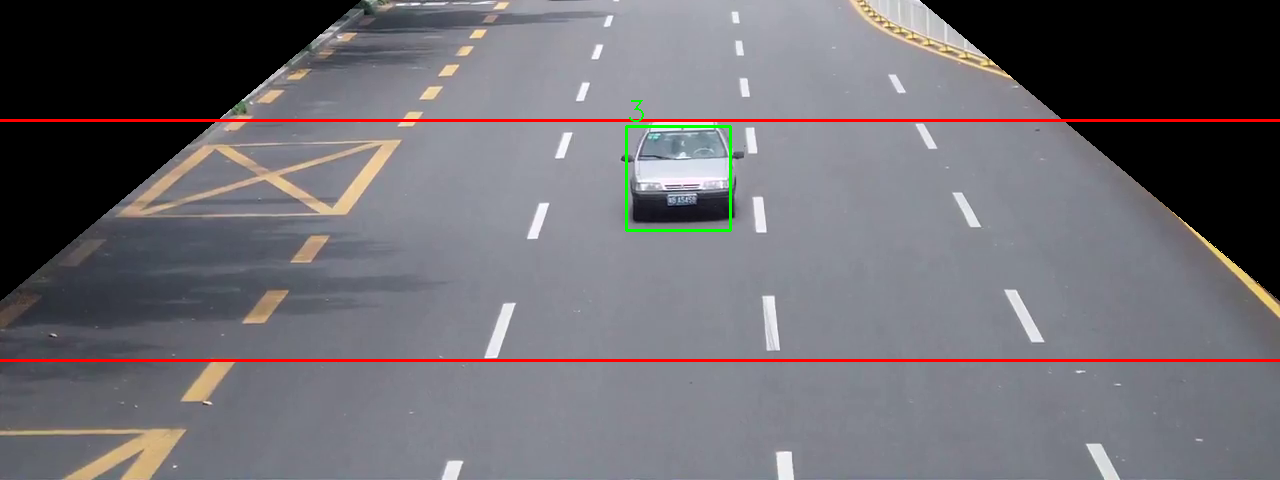

CAR-ID : 3 : 69.61 kmph - OVERSPEED


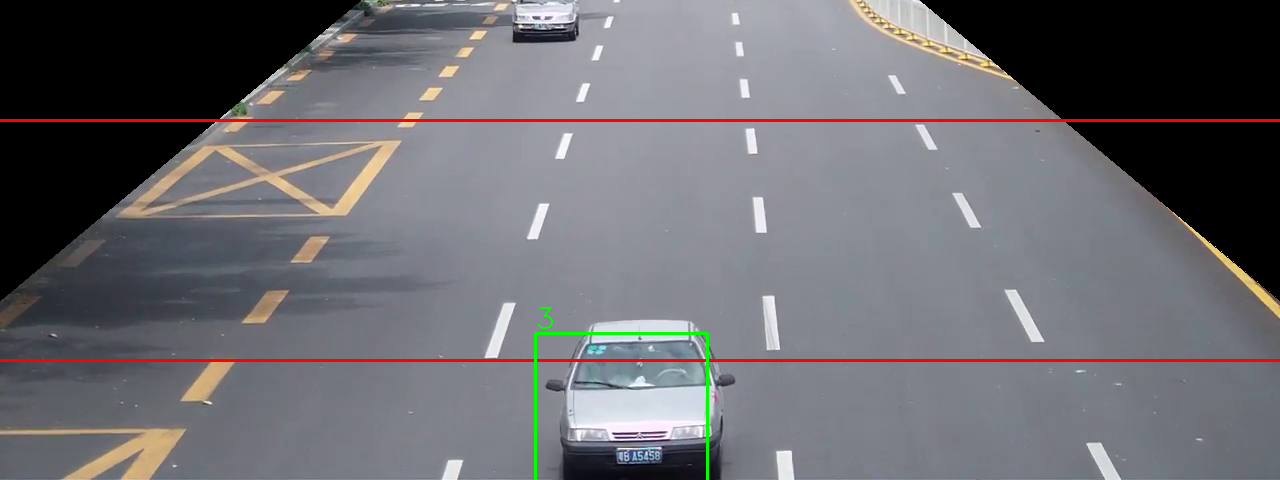

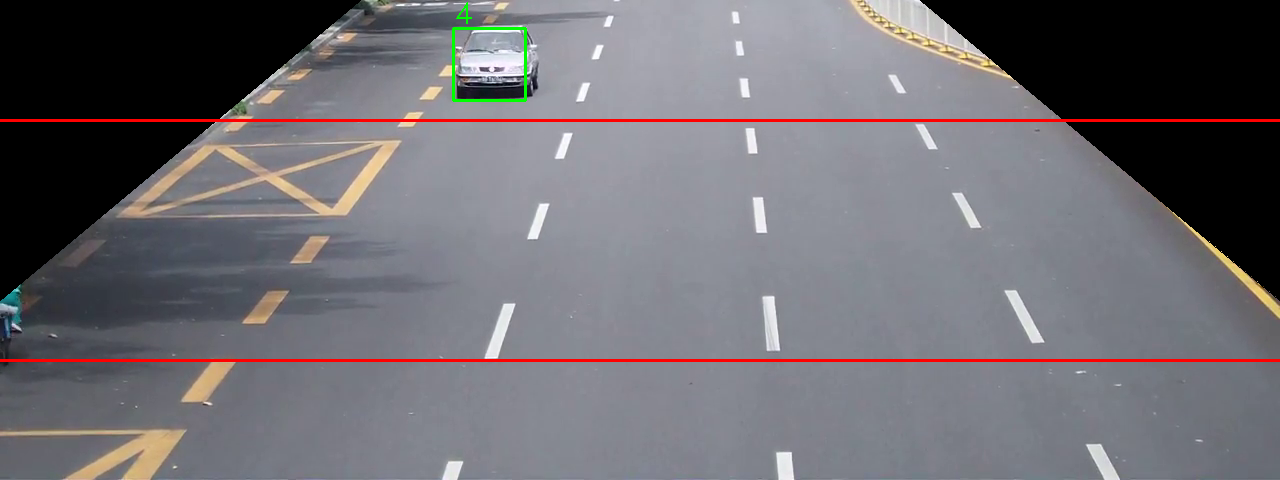

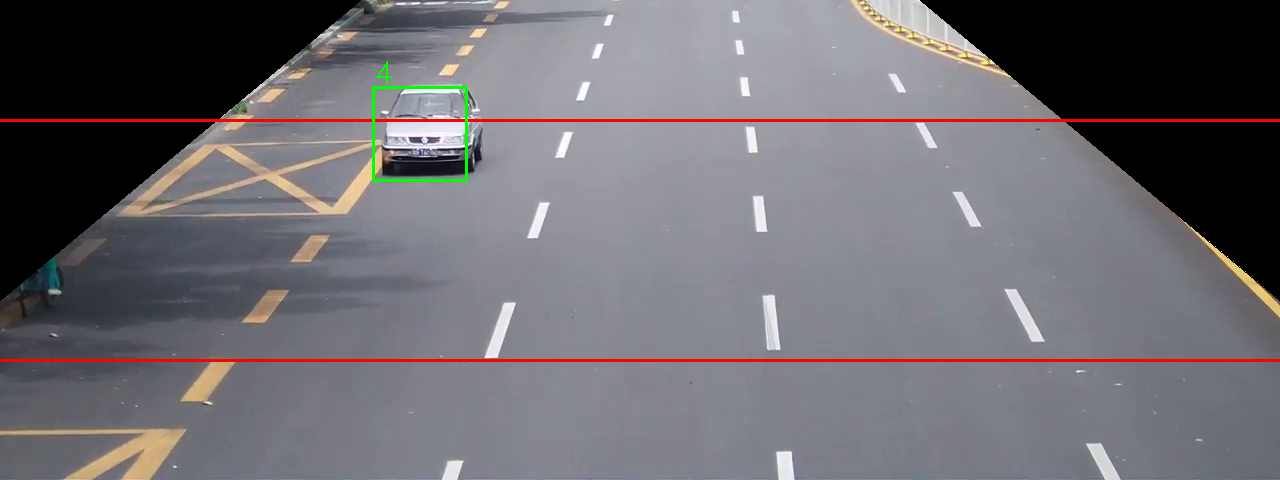

KeyboardInterrupt: ignored

In [8]:
import cv2
import dlib
import time
from datetime import datetime
import os
import numpy as np
from PIL import Image

#CLASSIFIER FOR DETECTING CARS--------------------------------------------------
carCascade = cv2.CascadeClassifier('HaarCascadeClassifier.xml')

#TAKE VIDEO---------------------------------------------------------------------
video = cv2.VideoCapture('videoTest.mp4')

WIDTH = 1280 #WIDTH OF VIDEO FRAME
HEIGHT = 720 #HEIGHT OF VIDEO FRAME
cropBegin = 240 #CROP VIDEO FRAME FROM THIS POINT
mark1 = 120 #MARK TO START TIMER
mark2 = 360 #MARK TO END TIMER
markGap = 15 #DISTANCE IN METRES BETWEEN THE MARKERS
fpsFactor = 3 #TO COMPENSATE FOR SLOW PROCESSING
speedLimit = 30 #SPEEDLIMIT
startTracker = {} #STORE STARTING TIME OF CARS
endTracker = {} #STORE ENDING TIME OF CARS

#MAKE DIRCETORY TO STORE OVER-SPEEDING CAR IMAGES
if not os.path.exists('overspeeding/cars/'):
    os.makedirs('overspeeding/cars/')

print('Speed Limit Set at 20 Kmph')


def blackout(image):
    xBlack = 360
    yBlack = 300
    triangle_cnt = np.array( [[0,0], [xBlack,0], [0,yBlack]] )
    triangle_cnt2 = np.array( [[WIDTH,0], [WIDTH-xBlack,0], [WIDTH,yBlack]] )
    cv2.drawContours(image, [triangle_cnt], 0, (0,0,0), -1)
    cv2.drawContours(image, [triangle_cnt2], 0, (0,0,0), -1)

    return image

#FUCTION TO SAVE CAR IMAGE, DATE, TIME, SPEED ----------------------------------
def saveCar(speed,image):
    now = datetime.today().now()
    nameCurTime = now.strftime("%d-%m-%Y-%H-%M-%S-%f")

    link = 'overspeeding/cars/'+nameCurTime+'.jpeg'
    cv2.imwrite(link,image)

#FUNCTION TO CALCULATE SPEED----------------------------------------------------
def estimateSpeed(carID):
    timeDiff = endTracker[carID]-startTracker[carID]
    speed = round(markGap/timeDiff*fpsFactor*3.6,2)
    return speed

#FUNCTION TO TRACK CARS---------------------------------------------------------
def trackMultipleObjects():
    rectangleColor = (0, 255, 0)
    frameCounter = 0
    currentCarID = 0
    carTracker = {}

    while True:
        rc, image = video.read()
        if type(image) == type(None):
            break

        frameTime = time.time()
        image = cv2.resize(image, (WIDTH, HEIGHT))[cropBegin:720,0:1280]
        resultImage = blackout(image)
        cv2.line(resultImage,(0,mark1),(1280,mark1),(0,0,255),2)
        cv2.line(resultImage,(0,mark2),(1280,mark2),(0,0,255),2)

        frameCounter = frameCounter + 1

        #DELETE CARIDs NOT IN FRAME---------------------------------------------
        carIDtoDelete = []

        for carID in carTracker.keys():
            trackingQuality = carTracker[carID].update(image)

            if trackingQuality < 7:
                carIDtoDelete.append(carID)

        for carID in carIDtoDelete:
            carTracker.pop(carID, None)

        #MAIN PROGRAM-----------------------------------------------------------
        if (frameCounter%60 == 0):
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cars = carCascade.detectMultiScale(gray, 1.1, 13, 18, (24, 24)) #DETECT CARS IN FRAME

            for (_x, _y, _w, _h) in cars:
                #GET POSITION OF A CAR
                x = int(_x)
                y = int(_y)
                w = int(_w)
                h = int(_h)

                xbar = x + 0.5*w
                ybar = y + 0.5*h

                matchCarID = None

                #IF CENTROID OF CURRENT CAR NEAR THE CENTROID OF ANOTHER CAR IN PREVIOUS FRAME THEN THEY ARE THE SAME
                for carID in carTracker.keys():
                    trackedPosition = carTracker[carID].get_position()

                    tx = int(trackedPosition.left())
                    ty = int(trackedPosition.top())
                    tw = int(trackedPosition.width())
                    th = int(trackedPosition.height())

                    txbar = tx + 0.5 * tw
                    tybar = ty + 0.5 * th

                    if ((tx <= xbar <= (tx + tw)) and (ty <= ybar <= (ty + th)) and (x <= txbar <= (x + w)) and (y <= tybar <= (y + h))):
                        matchCarID = carID


                if matchCarID is None:
                    tracker = dlib.correlation_tracker()
                    tracker.start_track(image, dlib.rectangle(x, y, x + w, y + h))

                    carTracker[currentCarID] = tracker

                    currentCarID = currentCarID + 1


        for carID in carTracker.keys():
            trackedPosition = carTracker[carID].get_position()

            tx = int(trackedPosition.left())
            ty = int(trackedPosition.top())
            tw = int(trackedPosition.width())
            th = int(trackedPosition.height())

            #PUT BOUNDING BOXES-------------------------------------------------
            cv2.rectangle(resultImage, (tx, ty), (tx + tw, ty + th), rectangleColor, 2)
            cv2.putText(resultImage, str(carID), (tx,ty-5), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 1)

            #ESTIMATE SPEED-----------------------------------------------------
            if carID not in startTracker and mark2 > ty+th > mark1 and ty < mark1:
                startTracker[carID] = frameTime

            elif carID in startTracker and carID not in endTracker and mark2 < ty+th:
                endTracker[carID] = frameTime
                speed = estimateSpeed(carID)
                if speed > speedLimit:
                    print('CAR-ID : {} : {} kmph - OVERSPEED'.format(carID, speed))
                    saveCar(speed,image[ty:ty+th, tx:tx+tw])
                else:
                    print('CAR-ID : {} : {} kmph'.format(carID, speed))

        #DISPLAY EACH FRAME
        if frameCounter % 50 == 0:
          from google.colab.patches import cv2_imshow
          cv2_imshow(resultImage)

        if cv2.waitKey(33) == 27:
            break

    cv2.destroyAllWindows()

if __name__ == '__main__':
    trackMultipleObjects()
